In [1]:
from lbg_forecast.likelihood import pack_params
from lbg_forecast.likelihood import unpack_params
from lbg_forecast.likelihood import get_cosmo_params
from lbg_forecast.likelihood import Likelihood

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


In [2]:
lhood = Likelihood()

Initialising likelihood
Initialisation Complete


In [3]:
cosmo_params = get_cosmo_params(define_cosmo())
blbg = np.array([3.])
bint = np.array([3.])

In [4]:
all_param = pack_params(cosmo_params, blbg, bint)
all_param

Array([ 0.8159,  0.2589,  0.0486,  0.6774,  0.9667, -1.    ,  3.    ,
        3.    ], dtype=float64)

In [5]:
unpack_params(all_param)

(Array([ 0.8159,  0.2589,  0.0486,  0.6774,  0.9667, -1.    ], dtype=float64),
 Array(3., dtype=float64),
 Array(3., dtype=float64))

In [6]:
lhood.logL(all_param)

Array(-4071.09009772, dtype=float64)

In [7]:
lhood.logLgauss(all_param)

Array(-4081.3205296, dtype=float64)

In [8]:
params = np.array([lhood._cosmo_fid.sigma8,
                  lhood._cosmo_fid.Omega_c,
                  lhood._cosmo_fid.Omega_b,
                  lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                  lhood._cosmo_fid.w0])

params = np.array([lhood._cosmo_fid.sigma8,
                  lhood._cosmo_fid.Omega_c,
                  lhood._cosmo_fid.Omega_b,
                  lhood._cosmo_fid.h, lhood._cosmo_fid.n_s, lhood._b_lbg])

#w&w stuff
#norm_diff = pk(define_cosmo(), 1/8, 2.6)/pk(define_cosmo(), 1/8, 0)
#params = np.array([lhood._cosmo_fid.sigma8*np.sqrt(norm_diff), lhood._b_lbg])

labels = np.array(["$\sigma8$", "$\Omega_c$", "$\Omega_b$",
                    "$h$", "$n_s$", "$w_0$"])

labels = np.array(["$\sigma8$", "$\Omega_c$", "$\Omega_b$",
                    "$h$", "$n_s$", "$b_{lbg}$"])

#labels = np.array(["$\sigma8$", "$b_{lbg}$"])

F = lhood.fisher(params)
F_marg = lhood.fisher_marg(params)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=3, K=5.991, ax=None, resize=False, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda k: np.sqrt(cov[k, k])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[[j, i]][::,[j, i]]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  #width, height = 2 * nstd * np.sqrt(vals)
  width, height = 2 * np.sqrt(vals*K)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  if resize:
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(i)
    s2 = 1.5*nstd*sigma_marg(j)
    ax.set_xlim(pos[i] - s1, pos[i] + s1)
    ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=3., K=5.991, ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  inds = [i, j]
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  #width, height = 2 * nstd * np.sqrt(vals)
  width, height = 2 * np.sqrt(vals*K)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)
  plt.draw()
  return ellip

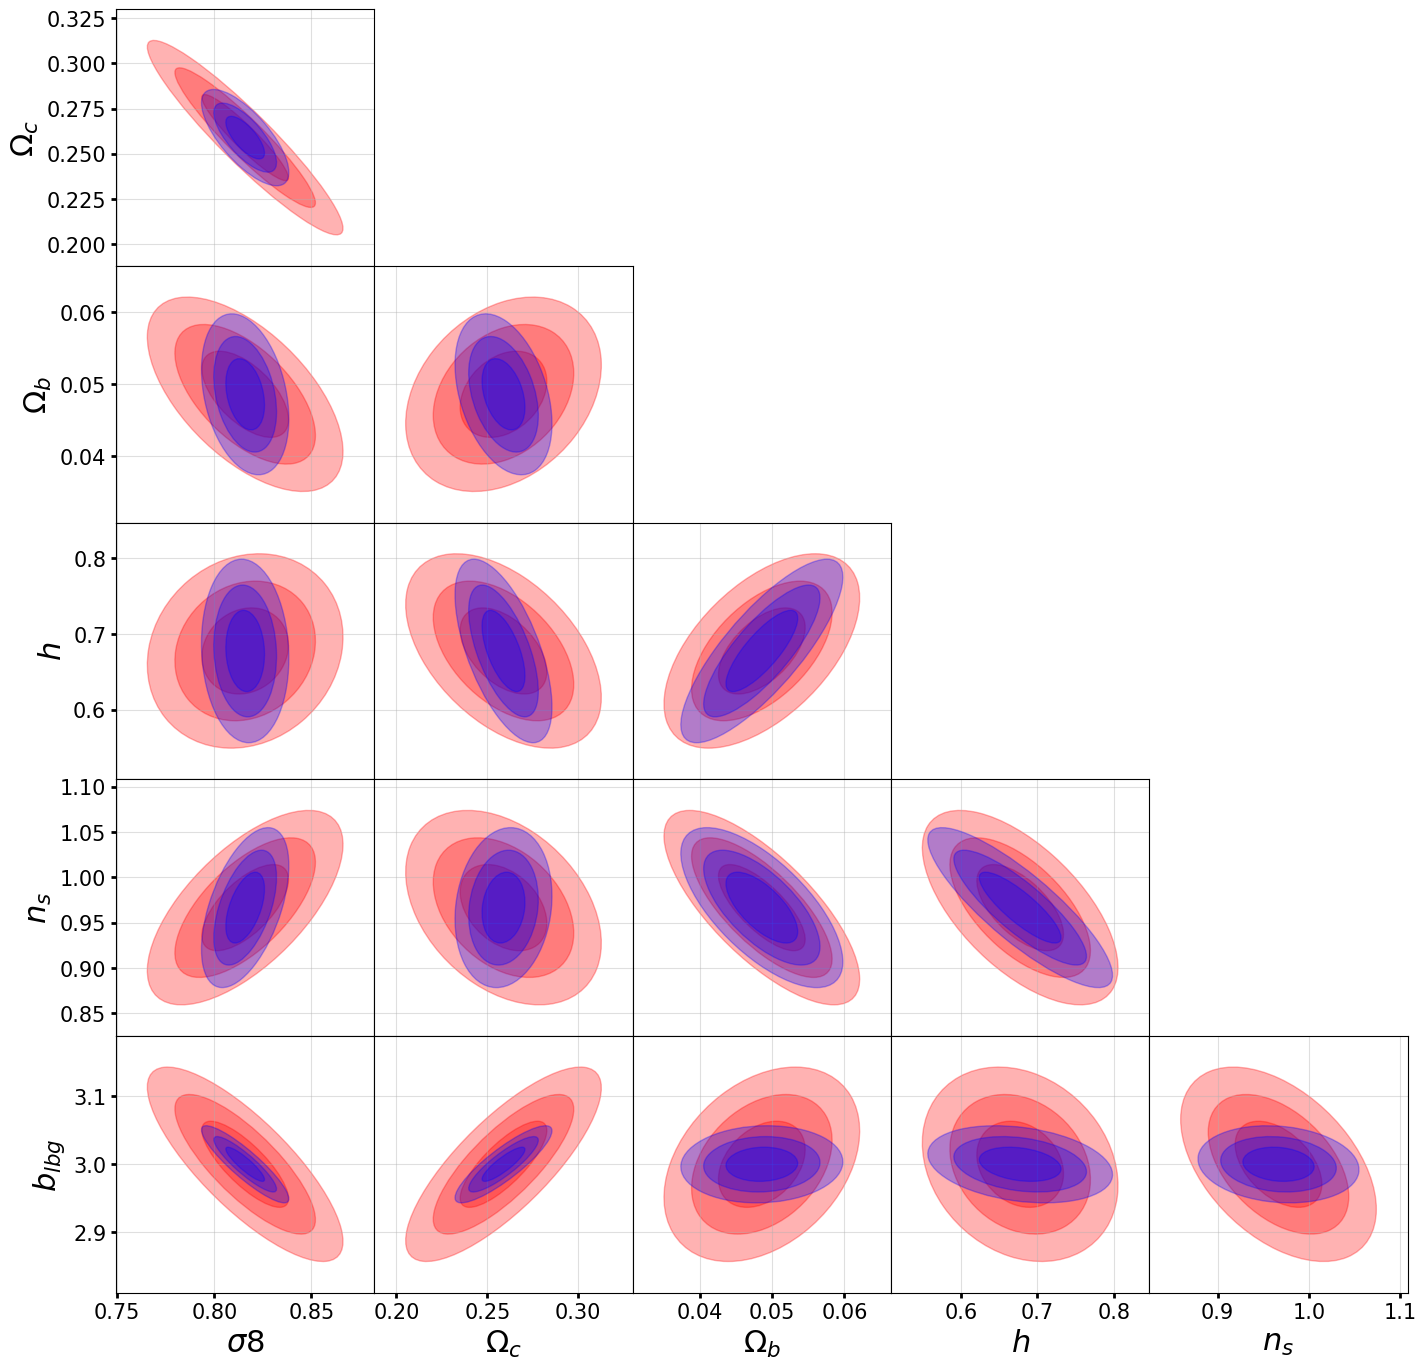

In [11]:
plt.figure(figsize=(20, 20))
nparams = len(params)

#randnos = np.random.multivariate_normal(np.array([params[0], params[1]]),
#                                         np.linalg.inv(F), 1000)

for i in range(nparams):
    for j in range(nparams):
        if j<i:
            plt.subplot(nparams,nparams,i*nparams+j+1)
            plt.subplots_adjust(wspace=0, hspace=0)


            plt.grid(alpha=0.4, zorder=-1)

            plot_contours(F, params, j, i, K=2.279, fill=True,color='b', alpha=0.3, zorder=5)
            plot_contours(F, params, j, i, K=5.991, fill=True,color='b',  alpha=0.3, zorder=5)
            #plot_contours(F, params, j, i, K=9.210, fill=True,color='b',  alpha=0.3, zorder=5)
            plot_contours(F, params, j, i, K=11.618, fill=True,color='b',  alpha=0.3, zorder=5)

            plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1)
            plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1)
            #plot_contours(F_marg, params, j, i, K=9.210, fill=True,color='r',  alpha=0.3, zorder=1)
            plot_contours(F_marg, params, j, i, K=11.618, fill=True,color='r', alpha=0.3, zorder=1)
            

            if(j == 0):
                plt.ylabel(labels[i], fontsize = 22)

            if(i == nparams-1):
                plt.xlabel(labels[j], fontsize = 22)

            plt.tick_params(axis="x", width = 2, labelsize=15)
            plt.tick_params(axis="y", width = 2, labelsize=15)

            if(i < len(params) - 1):
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    labelbottom=False)
                
            if(j > 0):
                plt.tick_params(
                    axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,        # ticks along the bottom edge are off
                    labelleft=False)
            #plt.scatter(randnos[:,0], randnos[:, 1], c ='r', zorder=100, alpha=.5, s=10)
                
                
            